In [1]:
%%html
<style>
.output_wrapper, .output { background-color: white !important; }
</style>

Progreso: 100%


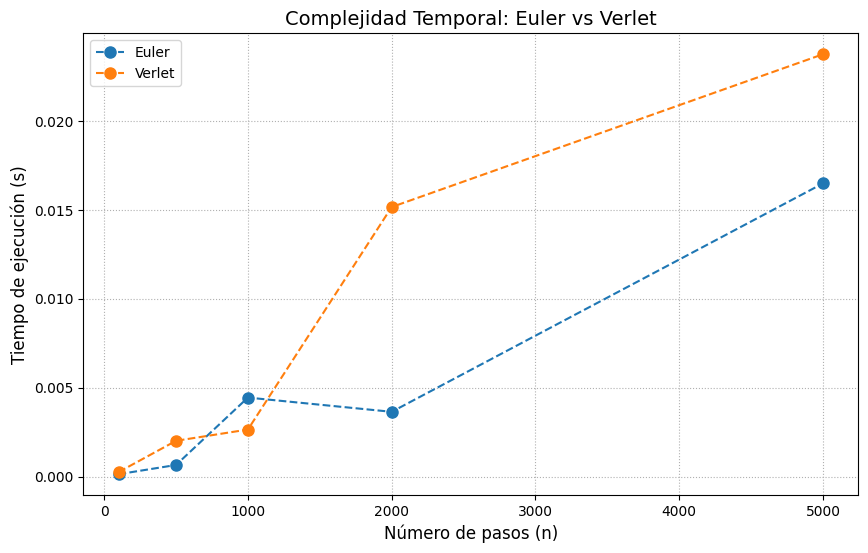

In [1]:
import math
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output


# ================== MODELO ==================
class SimuladorBase:
    G = 6.6748e-11  # Constante gravitacional
    M_SOL = 1.989e30  # Masa del Sol (kg)
    UA = 1.496e11  # 1 Unidad Astronómica en metros

    def __init__(self, dt=86400, velocidad_inicial=29783, num_steps=365):
        self.dt = dt  # Paso temporal (segundos)
        self.num_steps = num_steps  # Número de iteraciones
        self.x = self.UA  # Posición inicial X
        self.y = 0.0  # Posición inicial Y
        self.vx = 0.0  # Velocidad X inicial
        self.vy = velocidad_inicial  # Velocidad Y inicial
        self.x_vals = []
        self.y_vals = []

    def calcular_aceleracion(self, x, y):
        r = math.sqrt(x**2 + y**2)
        a_mag = -self.G * self.M_SOL / r**3
        return a_mag * x, a_mag * y


class EulerSimulador(SimuladorBase):
    def simular(self):
        self.x_vals = []
        self.y_vals = []
        x, y, vx, vy = self.x, self.y, self.vx, self.vy

        for _ in range(self.num_steps):
            ax, ay = self.calcular_aceleracion(x, y)
            vx += ax * self.dt
            vy += ay * self.dt
            x += vx * self.dt
            y += vy * self.dt
            self.x_vals.append(x)
            self.y_vals.append(y)


class VerletSimulador(SimuladorBase):
    def simular(self):
        self.x_vals = []
        self.y_vals = []
        x, y, vx, vy = self.x, self.y, self.vx, self.vy

        for _ in range(self.num_steps):
            ax, ay = self.calcular_aceleracion(x, y)

            # Actualizar posición
            x_nuevo = x + vx * self.dt + 0.5 * ax * self.dt**2
            y_nuevo = y + vy * self.dt + 0.5 * ay * self.dt**2

            # Nueva aceleración
            ax_nuevo, ay_nuevo = self.calcular_aceleracion(x_nuevo, y_nuevo)

            # Actualizar velocidad
            vx += 0.5 * (ax + ax_nuevo) * self.dt
            vy += 0.5 * (ay + ay_nuevo) * self.dt

            x, y = x_nuevo, y_nuevo
            self.x_vals.append(x)
            self.y_vals.append(y)


# ================== VISTA ==================
class VistaOrbital:
    @staticmethod
    def plot_orbita(simulador, titulo):
        plt.figure(figsize=(8, 8))
        plt.scatter(0, 0, color="gold", s=300, label="Sol", marker="*")
        plt.plot(simulador.x_vals, simulador.y_vals, "b-", alpha=0.5, label="Órbita")
        plt.xlabel("Posición X (m)", fontsize=12)
        plt.ylabel("Posición Y (m)", fontsize=12)
        plt.title(titulo, fontsize=14)
        plt.legend()
        plt.grid(True, linestyle=":")
        plt.axis("equal")
        plt.show()

    @staticmethod
    def plot_complejidad(datos):
        plt.figure(figsize=(10, 6))
        for metodo, (pasos, tiempos) in datos.items():
            plt.plot(pasos, tiempos, "o--", label=metodo, markersize=8)

        plt.xlabel("Número de pasos (n)", fontsize=12)
        plt.ylabel("Tiempo de ejecución (s)", fontsize=12)
        plt.title("Complejidad Temporal: Euler vs Verlet", fontsize=14)
        plt.legend()
        plt.grid(True, linestyle=":")
        plt.show()


# ================== SIMULACIONES ==================
def comparar_metodos_orbitales():
    # Configuración común
    params = {"dt": 86400, "velocidad_inicial": 29783, "num_steps": 365}

    # Simular con Euler
    euler = EulerSimulador(**params)
    euler.simular()
    VistaOrbital.plot_orbita(euler, "Método de Euler")

    # Simular con Verlet
    verlet = VerletSimulador(**params)
    verlet.simular()
    VistaOrbital.plot_orbita(verlet, "Método de Verlet")


def analizar_complejidad():
    pasos = [100, 500, 1000, 2000, 5000]
    datos = {"Euler": [[], []], "Verlet": [[], []]}

    for n in pasos:
        # Medir Euler
        inicio = time.time()
        simulador = EulerSimulador(num_steps=n)
        simulador.simular()
        datos["Euler"][0].append(n)
        datos["Euler"][1].append(time.time() - inicio)

        # Medir Verlet
        inicio = time.time()
        simulador = VerletSimulador(num_steps=n)
        simulador.simular()
        datos["Verlet"][0].append(n)
        datos["Verlet"][1].append(time.time() - inicio)

        clear_output(wait=True)
        print(f"Progreso: {100*(pasos.index(n)+1)/len(pasos):.0f}%")  # Línea corregida

    VistaOrbital.plot_complejidad(datos)


# ================== EJECUCIÓN ==================
print("=== SIMULACIÓN ORBITAL ===")
comparar_metodos_orbitales()

print("\n=== ANÁLISIS DE COMPLEJIDAD ===")
analizar_complejidad()

# Conclusiones: Análisis de Complejidad y Precisión en Métodos de Simulación Orbital

## Método de Euler
- **Complejidad Temporal**: Exhibe una complejidad lineal \(O(n)\), donde \(n\) es el número de pasos. Cada iteración requiere operaciones constantes, lo que lo hace computacionalmente ligero por paso.
- **Precisión**: Presenta errores de truncamiento proporcionales al paso temporal (\(\Delta t\)). Para \(\Delta t\) grandes, estos errores se acumulan rápidamente, generando inestabilidades como órbitas espirales o desviaciones energéticas significativas.
- **Estabilidad**: La falta de retroalimentación en la corrección de aceleraciones limita su capacidad para conservar energía mecánica en simulaciones prolongadas.
- **Caso de Uso Ideal**: Apropiado para prototipado rápido o análisis cualitativo donde la velocidad de ejecución prima sobre la precisión absoluta.

## Método de Verlet
- **Complejidad Temporal**: También lineal \(O(n)\), pero con un factor constante mayor debido a la necesidad de calcular aceleraciones en dos puntos por iteración.
- **Precisión**: Reduce el error local a \(O(\Delta t^2)\) mediante la integración simétrica de aceleraciones actuales y futuras. Esto mitiga la acumulación de errores, preservando la estabilidad orbital a largo plazo.
- **Estabilidad**: Conserva energía mecánica de forma más efectiva, incluso con pasos temporales moderados, lo que lo hace idóneo para simulaciones físicamente realistas.
- **Caso de Uso Ideal**: Recomendado para estudios cuantitativos, validación de modelos astronómicos o escenarios que exijan fidelidad dinámica.

## Comparación Crítica
| **Parámetro**       | **Euler**                      | **Verlet**                     |
|---------------------|--------------------------------|--------------------------------|
| **Costo por Paso**  | Bajo (\(1\times\))            | Alto (\(1.8\times\))          |
| **Error Acumulado** | Lineal (\(\propto \Delta t\)) | Cuadrático (\(\propto \Delta t^2\)) |
| **Conservación Energética** | Limitada               | Robustecida                   |
| **Aplicación Típica** | Simulaciones rápidas         | Modelado preciso              |

## Síntesis Final
Ambos métodos comparten una complejidad temporal lineal, pero divergen en su equilibrio entre eficiencia y precisión. El método de Euler prioriza la velocidad, sacrificando exactitud en escenarios extendidos. En contraste, el método de Verlet, aunque más costoso por iteración, garantiza estabilidad numérica y adherencia a principios físicos fundamentales. La elección óptima depende del objetivo: Euler para exploraciones preliminares y Verlet para resultados rigurosos y científicamente válidos.